### ЦЕЛЬ
Подготовить основу рекомендательной системы.

### ЗАДАЧИ
1. Составить таблицу, в которой курсам будет соответствовать по две рекомендации. То есть таблица должна иметь три столбца:

 - Курс, к которому идёт рекомендация. 
 - Курс для рекомендации № 1 (самый популярный).
 - Курс для рекомендации № 2 (второй по популярности).


2. Анализ результатов A/B-теста после внедрения таблицы с рекомендацией 



In [1]:
# иморт пакетов
from scipy.stats import norm
import math 
from scipy.stats import t
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import psycopg2
import psycopg2.extras
import seaborn as sns

In [2]:
# подключаемся БД skillfactory и импортируем сгруппированную таблицу с покупками пользователей
def getmore_than_one():
    query = '''WITH more_than_one  AS
(
SELECT 
    carts.user_id,
    count (items.resource_id)
FROM final.cart_items  AS  items
    JOIN final.carts ON items.cart_id = carts.id
WHERE resource_type = 'Course' AND state = 'successful' 
GROUP BY 1
HAVING count (distinct items.resource_id) > 1
)
SELECT 
    distinct more_than_one.user_id,
    items.resource_id
FROM more_than_one
    JOIN final.carts ON more_than_one.user_id = carts.user_id
    JOIN final.cart_items  AS items ON items.cart_id = carts.id
    WHERE resource_type = 'Course' AND state = 'successful'
ORDER BY 1,2'''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data
df = pd.DataFrame(getmore_than_one())

In [3]:
# составляем таблицу по пользователям и спискам их курсов
course_lists= df.groupby(['user_id'])['resource_id'].apply(lambda x:list(np.unique(x))).reset_index()
course_lists.head()

,user_id,resource_id
0,51,"[516, 1099]"
1,6117,"[356, 357, 1125]"
2,10275,"[553, 1147]"
3,10457,"[361, 1138]"
4,17166,"[356, 357]"


In [4]:
# составляем таблицу по курсам и количеству покупок этого курса
purchase_cnt_per_one = df.groupby(['resource_id'])['user_id'].count().reset_index()

In [5]:
purchase_cnt_per_one.rename(columns={'resource_id': 'course','user_id':'purchases'}, inplace=True)
purchase_cnt_per_one.head()

,course,purchases
0,356,351
1,357,360
2,358,76
3,359,57
4,360,43


In [6]:
# составляем парные комбинации курсов:
a = course_lists['resource_id'].apply(lambda x: list(itertools.combinations(x, 2))).reset_index()
a.head()

,index,resource_id
0,0,"[(516, 1099)]"
1,1,"[(356, 357), (356, 1125), (357, 1125)]"
2,2,"[(553, 1147)]"
3,3,"[(361, 1138)]"
4,4,"[(356, 357)]"


In [7]:
# формируем список всех возможных пар курсов
q=[]
for row in a['resource_id']:
    for elem in row:
        q.append(elem)
len(q)

40017

In [8]:
# создаем датафрейм со списком пар
list_index = list(range(0, 40017))
df = pd.DataFrame(list(zip(q, list_index)), columns = ['courses', 'index']) 
df.head()

,courses,index
0,"(516, 1099)",0
1,"(356, 357)",1
2,"(356, 1125)",2
3,"(357, 1125)",3
4,"(553, 1147)",4


In [9]:
# составляем таблицу с частотностью пар курсов
val_cnt = df['courses'].value_counts().reset_index()
val_cnt.rename(columns={'index':'courses','courses':'cnt'}, inplace=True) 
val_cnt.head()

,courses,cnt
0,"(551, 566)",797
1,"(515, 551)",417
2,"(489, 551)",311
3,"(523, 551)",304
4,"(566, 794)",290


### Обратим внимание также на тот факт, что одна из рекомендаций может встречаться слишком редко, поэтому следует выбрать в качестве рекомендации более популярный курс

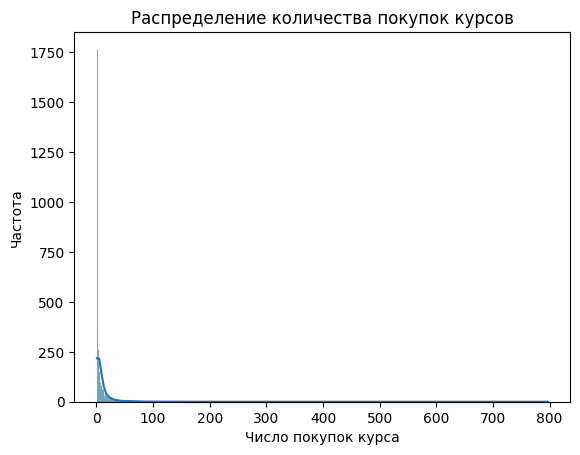

In [11]:
# строим гистограмму распределения покупок курсов
ax = sns.histplot(
    data=val_cnt,
    x=val_cnt['cnt'],
    kde=True    
)
ax.set (xlabel='Число покупок курса',
 ylabel='Частота',
 title='Распределение количества покупок курсов') 
plt.show() 

In [12]:
val_cnt['cnt'].describe()

count    3989.000000
mean       10.031838
std        26.355998
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       797.000000
Name: cnt, dtype: float64

#### Так как распределение ненормальное, большинство пар курсов покупали в количестве не больше 64, то за нижнюю гарницу беру значение медианы - 3, то есть если пару курсов покупали меньше 3 раз, то за пару не считаем и рекомендуем по альтернативной системе

За альтернативную систему рекомендаций предлагаю считать два самых популярных курса 

In [13]:
purchase_cnt_per_one = purchase_cnt_per_one.sort_values(by = 'purchases', ascending=False)
purchase_cnt_per_one.head(2)
# Самые популярные курсы - под номерами 551 и 566, их купили 2935 и 2342 раз соответственно.
# Поэтому для слабых связей курсов (меньше 3 покупок), предлагаю рекомендовать эти два популярных курса.

,course,purchases
30,551,2935
36,566,2342


In [14]:
# реализуем функцию рекомендаций (принимает на вход номер курса, возвращает 2 самых часто встречающихся с ним во всех парах курса)
val_cnt= val_cnt.sort_values(by = 'cnt',ascending=False)
# делим на таблицы с парами, имеющими три и более продаж, а также менее трех продаж:
val_cnt_top = val_cnt[val_cnt['cnt']>=3]
val_cnt_low = val_cnt[val_cnt['cnt']<3]

# формируем списки с курсами:
top = []
for i in val_cnt_top['courses']:
    for j in i:
        top.append(j)

low = []
for i in val_cnt_low['courses']:
    for j in i:
        low.append(j)

# реализуем функцию: 
def recomendation(course):
    recs=[]
    if course in top:
        for index, value in enumerate(top):
            if len(recs)==2:
                return(recs)
                break
            else:
                if value == course:
                    if index%2==0:
                        recs.append(top[index+1])
                    else:
                        recs.append(top[index-1])
    else:
        if course in low:
            return([551,566]) 


In [15]:
# проверяем работу функции
recomendation(552)

[551, 523]

In [16]:
# формируем таблицу с уникальными курсами:
courses = purchase_cnt_per_one.drop (columns=purchase_cnt_per_one.columns [1], axis= 1 )

In [17]:
# реализуем цикл с применением функции recomendation ко всем уникальным курсам и записываем результат в датафрейм courses
courses['recs'] = courses['course'].apply(lambda x: recomendation(x))

In [18]:
# разделяем стобец с рекомендациями на 2:
courses['rec1']=courses['recs'].str.get(0)
courses['rec2']=courses['recs'].str.get(1)

In [20]:
# Cоздаем итоговую таблицу с тремя столбцами, где:
#1. Курс, к которому идёт рекомендация
#2. Курс для рекомендации № 1 (самый популярный)
#3. Курс для рекомендации № 2 (второй по популярности)

recomendation_table = courses[['course','rec1','rec2']]
recomendation_table.head()

,course,rec1,rec2
30,551,566.0,515.0
36,566,551.0,794.0
24,515,551.0,489.0
13,489,551.0,515.0
14,490,566.0,551.0


Все клиенты случайным образом делятся на контрольную и тестовую группы: тестовой группе показываются рекомендации, а контрольной — нет.

До реализации рекомендаций средняя конверсия в покупку второго курса была 3,2%. 

Ожидается, что ввод рекомендаций сможет поднять её до 4%.

#### Определим минимальный размер выборки для проведения теста при уровне достоверности 95% и статистической мощности 80% с помощью https://www.evanmiller.org/ab-testing/sample-size.html 
Ответ: 7,866 чел. для каждой группы

## Оценка результатов
В контрольной группе оказалось 8732 клиента, оформивших заказ, из них 293 купили больше одного курса.

В тестовой — 8847 клиентов, из них 347 купили больше одного курса.

Уровень значимости различий проверяем с помощью https://abtestguide.com/calc/

- Конверсия контрольной группы оказалась 3.36%
- Конверсия экспермиентальной - 3.92%

Конверсия экспермиентальной группы оказалась выше контрольной на уровне значимости 0.0224, что позволяет сделать следующий вывод:
**рекомендации привели к статистически значимо лучшему результату, стоит реализовать их для всех клиентов**.